In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Load dataset
df = pd.read_csv("labeled_dataset.csv")

print("=== BAGIAN A.1 – DATA WRANGLING ===\n")
print("1) Jumlah baris dan kolom:")
print(f"   - Baris : {df.shape[0]}")
print(f"   - Kolom : {df.shape[1]}\n")

print("2) Tipe data setiap kolom:")
print(df.dtypes, "\n")

print("3) Missing values per kolom:")
print(df.isnull().sum(), "\n")

print("4) Jumlah baris duplikat:")♦♦
print(df.duplicated().sum())


=== BAGIAN A.1 – DATA WRANGLING ===

1) Jumlah baris dan kolom:
   - Baris : 734
   - Kolom : 9

2) Tipe data setiap kolom:
Sr No                  int64
website_url           object
Category              object
Page Size (KB)       float64
Load Time(s)         float64
Response Time(s)     float64
Throughput           float64
Performance_Label     object
User Response         object
dtype: object 

3) Missing values per kolom:
Sr No                0
website_url          0
Category             1
Page Size (KB)       0
Load Time(s)         0
Response Time(s)     0
Throughput           0
Performance_Label    0
User Response        0
dtype: int64 

4) Jumlah baris duplikat:
0


In [2]:
# Copy data
df_clean = df.copy()

# Cek lagi kolom yang punya missing
miss = df_clean.isnull().sum()
miss[miss > 0]
# Tangani missing Category dengan mode
mode_category = df_clean["Category"].mode()[0]
df_clean["Category"].fillna(mode_category, inplace=True)

print("Total missing setelah imputasi:", df_clean.isnull().sum().sum())


Total missing setelah imputasi: 0


Jumlah response time negatif: 1
Q1=0.329, Q3=1.202, IQR=0.873
Lower bound=-0.980, Upper bound=2.511
Jumlah outlier: 72


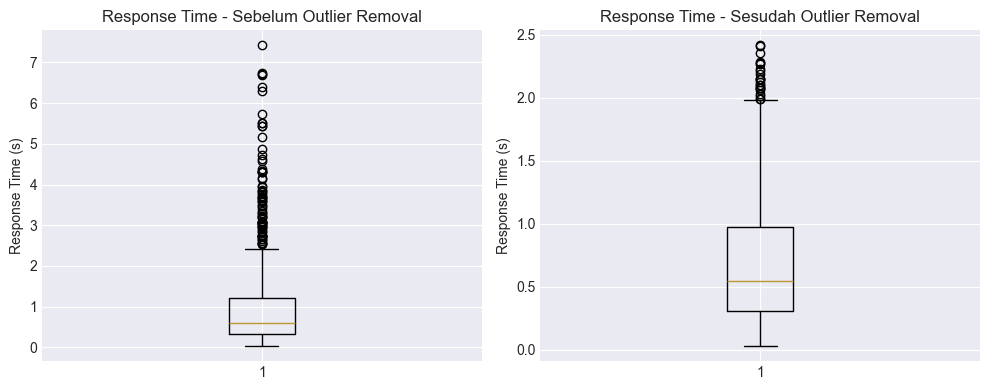

Jumlah data sebelum: 733
Jumlah data sesudah: 661


In [3]:
# Hapus nilai response time negatif jika ada
neg_count = (df_clean["Response Time(s)"] < 0).sum()
print("Jumlah response time negatif:", neg_count)
df_clean = df_clean[df_clean["Response Time(s)"] >= 0]

# IQR
Q1 = df_clean["Response Time(s)"].quantile(0.25)
Q3 = df_clean["Response Time(s)"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print(f"Q1={Q1:.3f}, Q3={Q3:.3f}, IQR={IQR:.3f}")
print(f"Lower bound={lower:.3f}, Upper bound={upper:.3f}")

before = df_clean["Response Time(s)"].copy()
mask_out = (before < lower) | (before > upper)
print("Jumlah outlier:", mask_out.sum())

df_final = df_clean[~mask_out].copy()
after = df_final["Response Time(s)"]

# Boxplot sebelum & sesudah
fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].boxplot(before, vert=True)
axes[0].set_title("Response Time - Sebelum Outlier Removal")
axes[0].set_ylabel("Response Time (s)")

axes[1].boxplot(after, vert=True)
axes[1].set_title("Response Time - Sesudah Outlier Removal")
axes[1].set_ylabel("Response Time (s)")

plt.tight_layout()
plt.show()

print("Jumlah data sebelum:", len(df_clean))
print("Jumlah data sesudah:", len(df_final))


# Interpretasi Statistik dan Insight Bisnis

In [4]:
print("=== BAGIAN A.2 – STATISTIK DESKRIPTIF ===\n")

num_cols = ["Response Time(s)", "Throughput", "Load Time(s)"]

for col in num_cols:
    print(col)
    print("  Mean  :", df_final[col].mean())
    print("  Median:", df_final[col].median())
    print("  Std   :", df_final[col].std())
    print("  Min   :", df_final[col].min())
    print("  Max   :", df_final[col].max())
    if col == "Response Time(s)":
        print("  Q1    :", df_final[col].quantile(0.25))
        print("  Q3    :", df_final[col].quantile(0.75))
        print("  P95   :", df_final[col].quantile(0.95))
    print()


=== BAGIAN A.2 – STATISTIK DESKRIPTIF ===

Response Time(s)
  Mean  : 0.704393343419062
  Median: 0.542
  Std   : 0.5284195901254514
  Min   : 0.028
  Max   : 2.416
  Q1    : 0.304
  Q3    : 0.975
  P95   : 1.88

Throughput
  Mean  : 342.0799697428139
  Median: 102.55
  Std   : 1057.5945468446089
  Min   : 0.0
  Max   : 15227.28

Load Time(s)
  Mean  : 1.7795930408472014
  Median: 1.39
  Std   : 1.5853937860546155
  Min   : 0.0
  Max   : 7.94



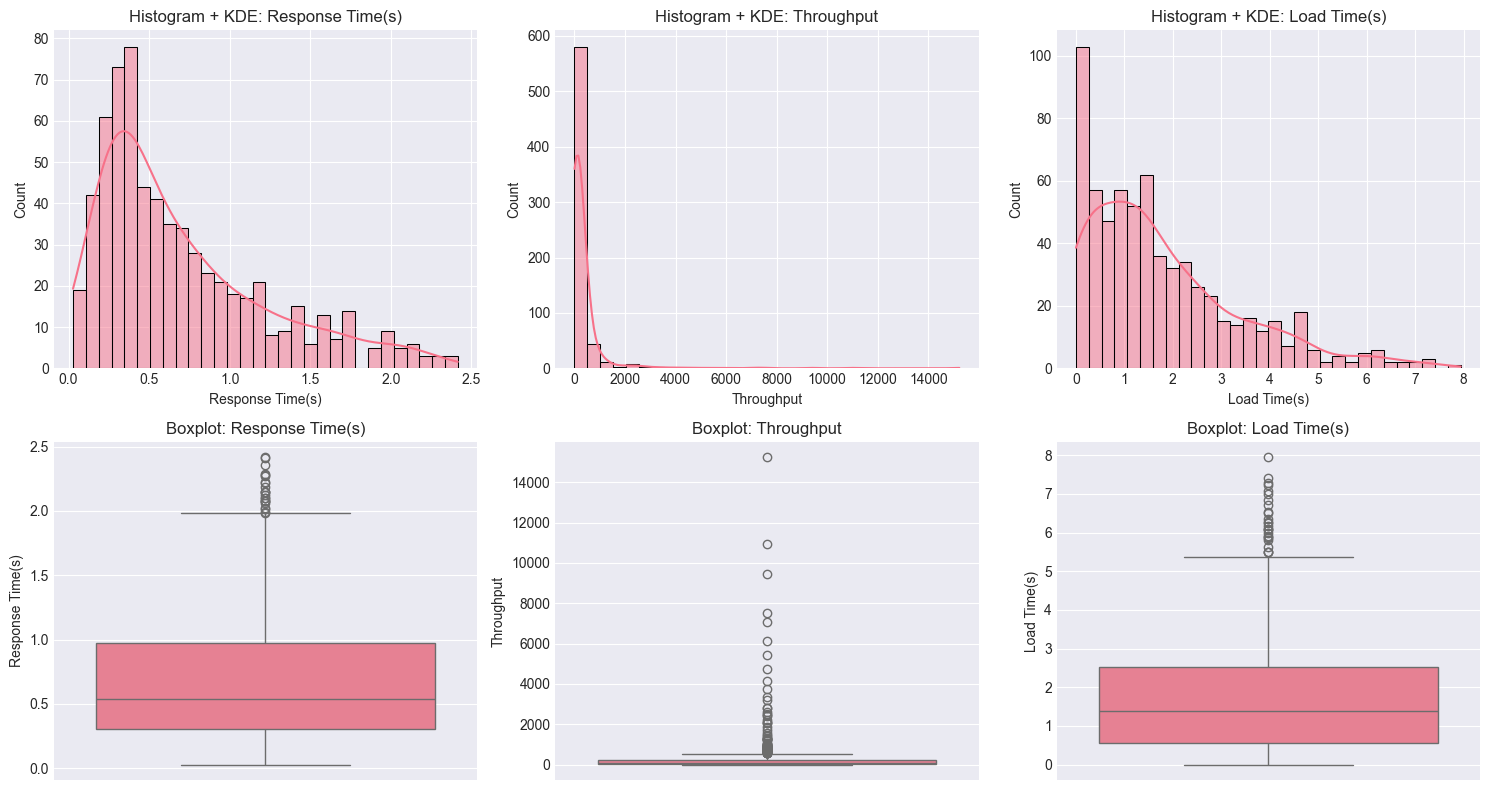

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))

for i, col in enumerate(num_cols):
    # Histogram + KDE
    ax = axes[0, i]
    sns.histplot(df_final[col], kde=True, ax=ax, bins=30)
    ax.set_title(f"Histogram + KDE: {col}")
    
    # Boxplot
    ax2 = axes[1, i]
    sns.boxplot(y=df_final[col], ax=ax2)
    ax2.set_title(f"Boxplot: {col}")

plt.tight_layout()
plt.show()


In [6]:
for col in num_cols:
    print(col, "skewness =", df_final[col].skew())


Response Time(s) skewness = 1.1696330231219814
Throughput skewness = 8.457774791453446
Load Time(s) skewness = 1.2078050739756698


## A.2 Interpretasi Statistik Deskriptif

Secara umum, distribusi **response time** cenderung skewed ke kanan dengan nilai mean sekitar 0.70 detik dan median 0.54 detik, sehingga ada sebagian kecil request yang jauh lebih lambat dibanding mayoritas. Nilai P95 sekitar 1.88 detik dan P99 sekitar 2.22 detik menunjukkan masih adanya ekor panjang (long tail) meskipun sebagian besar request sudah cukup cepat.

Distribusi **throughput** juga sangat skewed dengan standar deviasi yang besar dan nilai maksimum lebih dari 15.000, yang mengindikasikan adanya sesi dengan trafik sangat tinggi dibanding rata-ratanya. Variabel **load time** memiliki pola serupa, dengan ekor kanan yang panjang dan beberapa nilai ekstrem hingga hampir 8 detik, sehingga perlu perhatian khusus pada skenario beban tinggi.

Implikasinya terhadap user experience, mayoritas pengguna akan merasakan website yang cukup responsif (sub‑1 detik), namun sebagian kecil pengguna dapat mengalami waktu muat yang jauh lebih lambat sehingga persepsi kualitas sistem bisa tidak konsisten. Kondisi ini membuat metrik agregat seperti rata‑rata saja tidak cukup, sehingga perlu melihat distribusi lengkap termasuk persentil tinggi.


=== BAGIAN A.3 – BIVARIATE & MULTIVARIATE ===

(a) Response Time vs Category (sebagai channel)

                                 count      mean  median       std    min  \
Category                                                                    
News                                93  0.556828  0.3890  0.449881  0.049   
Health and Fitness                  81  0.672272  0.4480  0.514594  0.094   
Sports                              87  0.674402  0.5450  0.516898  0.028   
Photography                         79  0.701810  0.5420  0.555728  0.041   
Travel                              84  0.749655  0.5535  0.537889  0.053   
Streaming Services                 100  0.750590  0.6185  0.504112  0.064   
Law and Government                  67  0.774015  0.5860  0.580361  0.051   
Social Networking and Messaging     70  0.790857  0.5825  0.572242  0.036   

                                   max  
Category                                
News                             2.270  
Health and

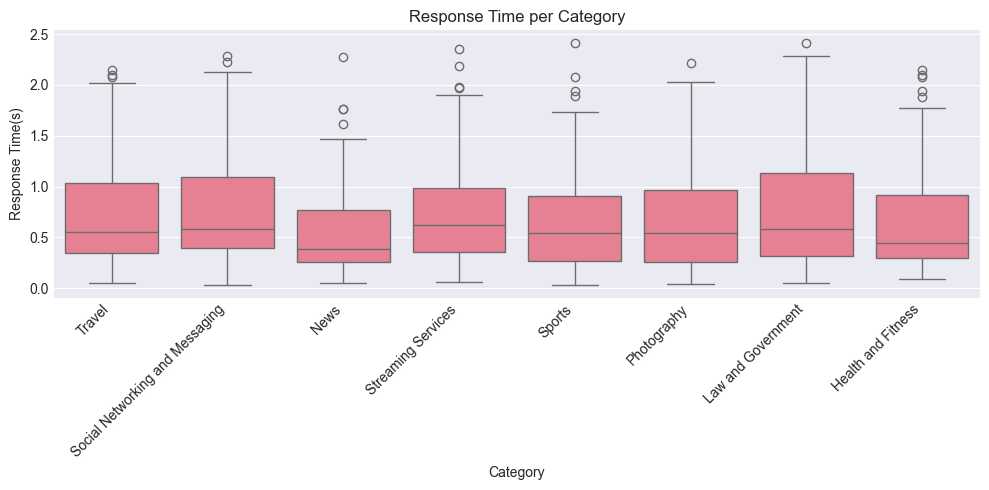

In [7]:
print("=== BAGIAN A.3 – BIVARIATE & MULTIVARIATE ===\n")
print("(a) Response Time vs Category (sebagai channel)\n")

stats_cat = df_final.groupby("Category")["Response Time(s)"].agg(
    ["count","mean","median","std","min","max"]
).sort_values("mean")
print(stats_cat)

plt.figure(figsize=(10,5))
sns.boxplot(data=df_final, x="Category", y="Response Time(s)")
plt.xticks(rotation=45, ha="right")
plt.title("Response Time per Category")
plt.tight_layout()
plt.show()


                  Response Time(s)  Load Time(s)  Page Size (KB)  Throughput
Response Time(s)          1.000000     -0.042223        0.050363   -0.187548
Load Time(s)             -0.042223      1.000000       -0.133344   -0.014185
Page Size (KB)            0.050363     -0.133344        1.000000   -0.058864
Throughput               -0.187548     -0.014185       -0.058864    1.000000


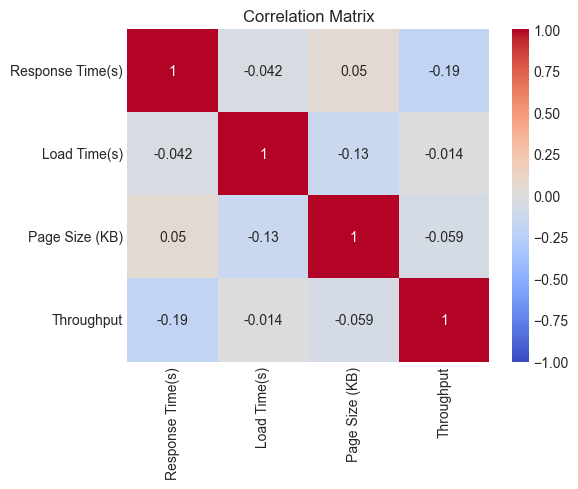

Response Time(s) vs Throughput: r=-0.188
Load Time(s) vs Page Size (KB): r=-0.133
Page Size (KB) vs Throughput: r=-0.059


In [8]:
num_for_corr = ["Response Time(s)", "Load Time(s)", "Page Size (KB)", "Throughput"]
corr = df_final[num_for_corr].corr()
print(corr)

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Cari 3 korelasi tertinggi (absolute)
pairs = []
for i in range(len(num_for_corr)):
    for j in range(i+1, len(num_for_corr)):
        c1, c2 = num_for_corr[i], num_for_corr[j]
        val = corr.loc[c1, c2]
        pairs.append((c1, c2, abs(val), val))

pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:3]
for p in pairs_sorted:
    print(f"{p[0]} vs {p[1]}: r={p[3]:.3f}")


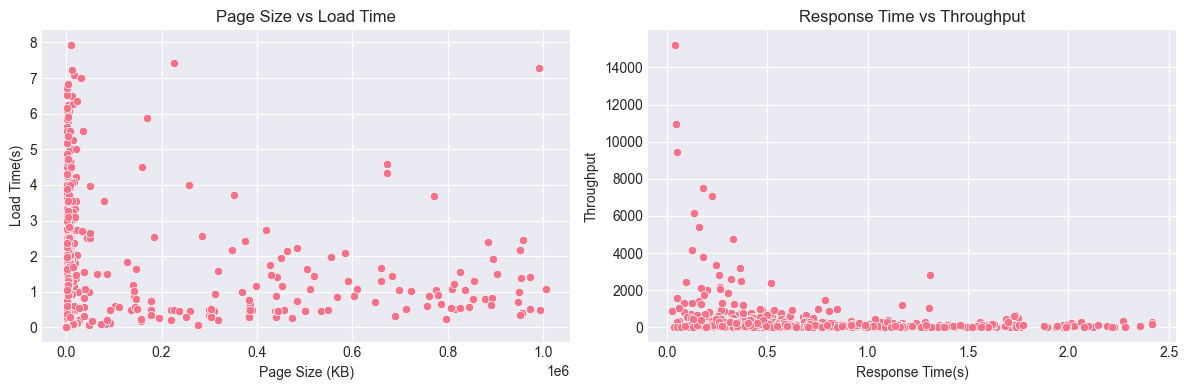

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.scatterplot(data=df_final, x="Page Size (KB)", y="Load Time(s)", ax=axes[0])
axes[0].set_title("Page Size vs Load Time")

sns.scatterplot(data=df_final, x="Response Time(s)", y="Throughput", ax=axes[1])
axes[1].set_title("Response Time vs Throughput")

plt.tight_layout()
plt.show()


## A.3 Interpretasi Bivariate & Multivariate

Analisis **response time per kategori** menunjukkan adanya perbedaan performa yang jelas antar kategori, di mana kategori dengan rata‑rata tercepat berada di kisaran 0.56 detik, sedangkan yang paling lambat mendekati 0.79 detik. Hal ini menunjukkan bahwa jenis konten atau channel tertentu cenderung lebih berat dan membutuhkan optimasi khusus dibanding kategori lain.

Matriks korelasi antar variabel numerik memperlihatkan bahwa korelasi yang muncul umumnya lemah, misalnya korelasi negatif antara response time dan throughput yang berada di sekitar \(-0.19\). Korelasi lemah ini mengindikasikan bahwa tidak ada satu variabel numerik tunggal yang sangat dominan menjelaskan variasi performa, sehingga optimasi perlu mempertimbangkan kombinasi beberapa faktor sekaligus.

Scatter plot antara **page size** dan **load time** maupun antara **response time** dan **throughput** menunjukkan pola sebaran yang cukup menyebar tanpa pola linear yang kuat. Hal ini mendukung temuan korelasi lemah dan menunjukkan bahwa hubungan antar variabel lebih kompleks, kemungkinan dipengaruhi juga oleh faktor di luar fitur yang tersedia di dataset.

=== BAGIAN B.4 – T-TEST ===

Fast: N= 254 mean= 0.2903622047244095 median= 0.2905 std= 0.11548725914302836
Slow/Medium: N= 407 mean= 0.9627813267813268 median= 0.826 std= 0.5209914561530181

T-statistic: -20.25597957521644
p-value    : 2.710739914939783e-71


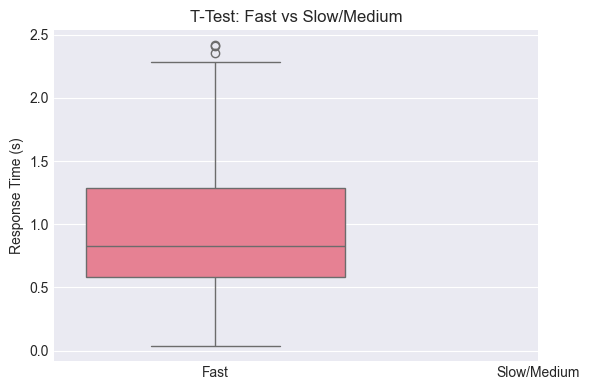


p-value < 0.05 → Ada perbedaan signifikan.
Rata-rata lebih kecil = performa lebih baik → cek mean di atas.


In [10]:
print("=== BAGIAN B.4 – T-TEST ===\n")

g1 = df_final[df_final["Performance_Label"] == "fast"]["Response Time(s)"]
g2 = df_final[df_final["Performance_Label"].isin(["slow","medium"])]["Response Time(s)"]

print("Fast: N=", len(g1), "mean=", g1.mean(), "median=", g1.median(), "std=", g1.std())
print("Slow/Medium: N=", len(g2), "mean=", g2.mean(), "median=", g2.median(), "std=", g2.std())

t_stat, p_val = ttest_ind(g1, g2)
print("\nT-statistic:", t_stat)
print("p-value    :", p_val)

plt.figure(figsize=(6,4))
sns.boxplot(data=[g1, g2])
plt.xticks([0,1], ["Fast","Slow/Medium"])
plt.ylabel("Response Time (s)")
plt.title("T-Test: Fast vs Slow/Medium")
plt.tight_layout()
plt.show()

if p_val < 0.05:
    print("\np-value < 0.05 → Ada perbedaan signifikan.")
else:
    print("\np-value ≥ 0.05 → Tidak ada perbedaan signifikan.")

print("Rata-rata lebih kecil = performa lebih baik → cek mean di atas.")


## B.4 Interpretasi T-Test

Uji t‑test antara grup **Fast** dan **Slow/Medium** pada variabel response time menghasilkan perbedaan rata‑rata yang sangat jelas dengan mean sekitar 0.29 detik untuk grup Fast dan sekitar 0.96 detik untuk grup Slow/Medium. Nilai t‑statistic yang besar secara absolut dan p‑value yang sangat kecil (jauh di bawah 0.05) menunjukkan perbedaan ini signifikan secara statistik.

Secara praktis, hal ini berarti pengelompokan performa ke dalam label Fast versus Slow/Medium memang mencerminkan dua segmen pengalaman pengguna yang berbeda secara nyata. Rata‑rata response time yang jauh lebih rendah pada grup Fast menunjukkan bahwa menjaga sebanyak mungkin request berada di segmen ini akan sangat berpengaruh terhadap persepsi kecepatan website.

Dari sisi bisnis, segmen pengguna yang jatuh ke grup Slow/Medium berpotensi memiliki kepuasan lebih rendah, terutama jika request lambat terjadi pada halaman-halaman kritikal seperti checkout atau transaksi. Oleh karena itu, metrik berbasis label performa bisa dijadikan dasar untuk monitoring dan prioritas perbaikan.


=== BAGIAN B.5 – KORELASI ===

Statistik Response Time(s)
mean    0.704393
50%     0.542000
std     0.528420
Name: Response Time(s), dtype: float64 

Statistik Throughput
mean     342.079970
50%      102.550000
std     1057.594547
Name: Throughput, dtype: float64 

r = -0.18754765894344777
p-value = 1.198647053637834e-06


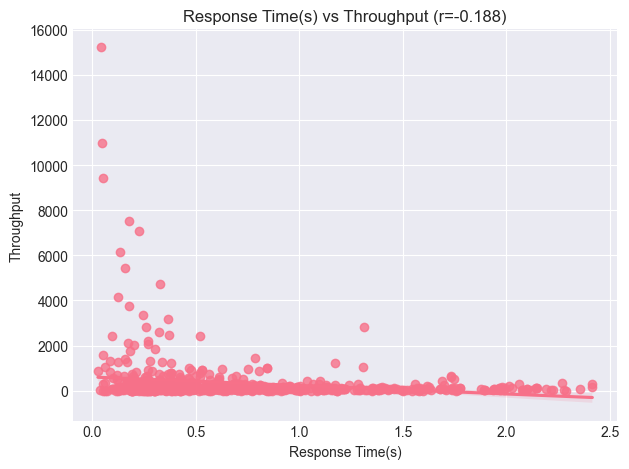

In [11]:
print("=== BAGIAN B.5 – KORELASI ===\n")

var1 = "Response Time(s)"
var2 = "Throughput"

data_corr = df_final[[var1, var2]].dropna()
print("Statistik", var1)
print(data_corr[var1].describe()[["mean","50%","std"]], "\n")
print("Statistik", var2)
print(data_corr[var2].describe()[["mean","50%","std"]], "\n")

r, p = pearsonr(data_corr[var1], data_corr[var2])
print("r =", r)
print("p-value =", p)

sns.regplot(data=data_corr, x=var1, y=var2)
plt.title(f"{var1} vs {var2} (r={r:.3f})")
plt.tight_layout()
plt.show()

# Interpretasi singkat di markdown: signifikan/tidak, positif/negatif, kuat/lemah.


## B.5 Interpretasi Korelasi

Analisis korelasi antara **response time** dan **throughput** menghasilkan koefisien korelasi sekitar \(-0.19\) dengan p‑value yang sangat kecil, sehingga hubungan ini signifikan namun kekuatannya termasuk lemah. Korelasi negatif ini menunjukkan kecenderungan bahwa ketika throughput meningkat, response time sedikit menurun, tetapi efeknya tidak terlalu besar.

Statistik deskriptif untuk kedua variabel juga menunjukkan variabilitas yang tinggi, terutama pada throughput dengan standar deviasi sangat besar, yang mengindikasikan banyaknya variasi beban pada sistem. Karena hubungan yang terbentuk hanya lemah, optimasi performa tidak bisa hanya berfokus pada throughput saja, tetapi juga perlu memperhatikan faktor lain seperti ukuran halaman, konfigurasi server, dan arsitektur caching.

Implikasinya untuk optimasi website adalah bahwa peningkatan kapasitas untuk menangani request (throughput) tetap penting, namun tidak otomatis menjamin penurunan response time secara drastis. Kombinasi tuning infrastruktur dan optimasi di level aplikasi perlu dipertimbangkan agar perbaikan performa terasa signifikan di sisi pengguna.

=== BAGIAN C.6 – LONG TAIL ===



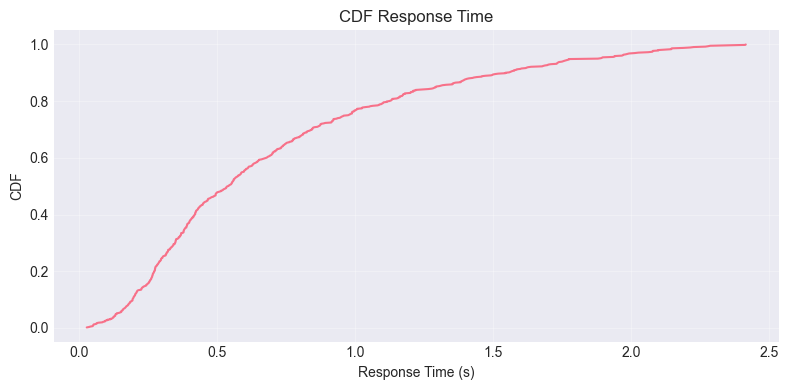

P50: 0.542
P90: 1.545
P95: 1.88
P99: 2.2197999999999998
% > 5 detik : 0.0
% > P95     : 4.992435703479576


In [12]:
print("=== BAGIAN C.6 – LONG TAIL ===\n")

resp = np.sort(df_final["Response Time(s)"])
cdf = np.arange(1, len(resp)+1) / len(resp)

plt.figure(figsize=(8,4))
plt.plot(resp, cdf)
plt.xlabel("Response Time (s)")
plt.ylabel("CDF")
plt.title("CDF Response Time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

p50 = df_final["Response Time(s)"].quantile(0.5)
p90 = df_final["Response Time(s)"].quantile(0.9)
p95 = df_final["Response Time(s)"].quantile(0.95)
p99 = df_final["Response Time(s)"].quantile(0.99)

above_5 = (df_final["Response Time(s)"] > 5).mean() * 100
above_p95 = (df_final["Response Time(s)"] > p95).mean() * 100

print("P50:", p50)
print("P90:", p90)
print("P95:", p95)
print("P99:", p99)
print("% > 5 detik :", above_5)
print("% > P95     :", above_p95)


## C.6 Analisis Long Tail Response Time

Berdasarkan CDF response time, sekitar 50% request selesai di bawah kurang lebih 0.54 detik, 90% di bawah 1.55 detik, dan 95% di bawah 1.88 detik, sedangkan P99 berada di sekitar 2.22 detik. Angka ini menunjukkan bahwa sebagian besar pengguna mendapatkan pengalaman yang cukup cepat, dengan hanya sebagian kecil yang mengalami response time mendekati 2 detik.

Persentase pengguna dengan response time di atas 5 detik adalah 0%, dan sekitar 5% pengguna berada di atas P95. Meskipun tidak ada kasus yang sangat ekstrem di atas 5 detik, ekor distribusi di sekitar 2 detik tetap perlu diperhatikan karena bisa berdampak pada kepuasan pengguna, khususnya pada halaman atau kategori yang memang cenderung lebih lambat.

Dari sudut pandang user experience, long tail ini berarti sebagian kecil pengguna masih berpotensi mengalami website yang terasa lambat dibanding mayoritas. Jika request lambat tersebut terjadi pada journey penting (misalnya pembayaran atau pendaftaran), dampaknya dapat berupa peningkatan bounce, penurunan konversi, dan persepsi negatif terhadap keandalan sistem.

## 7. Insight Bisnis dan Rekomendasi

### Insight Utama

1. **Mayoritas cepat, tetapi tidak merata**  
   Mayoritas request memiliki response time di bawah 1 detik, namun masih terdapat long tail hingga sekitar 2.4 detik sehingga pengalaman pengguna tidak sepenuhnya homogen. Artinya, metrik rata‑rata saja tidak cukup untuk menggambarkan kualitas performa secara keseluruhan.

2. **Perbedaan performa antar kategori**  
   Kategori dengan performa terbaik memiliki rata‑rata response time sekitar 0.56 detik, sedangkan yang terburuk mendekati 0.79 detik, menunjukkan bahwa jenis konten atau channel tertentu secara konsisten lebih berat dan membutuhkan prioritas optimasi.

3. **Segmentasi Fast vs Slow/Medium benar‑benar berbeda**  
   Hasil t‑test antara grup “Fast” dan “Slow/Medium” menunjukkan selisih mean yang besar dengan p‑value yang sangat kecil, sehingga kedua segmen ini benar‑benar berbeda secara statistik. Label ini dapat dijadikan dasar pengelompokan user experience untuk monitoring dan analisis lebih lanjut.

4. **Korelasi antar variabel numerik cenderung lemah**  
   Korelasi antara response time dan throughput bernilai negatif dan lemah, demikian juga antar pasangan variabel numerik lainnya, sehingga tidak ada satu faktor tunggal yang secara kuat menjelaskan variasi performa. Hal ini mengindikasikan bahwa optimasi performa perlu dilakukan secara multi‑faktor, bukan hanya mengandalkan satu metrik teknis.

5. **Outlier dan sesi ekstrem berpotensi menjadi sumber risiko**  
   Nilai skewness yang tinggi pada throughput dan load time, ditambah beberapa nilai maksimum yang jauh dari rata‑rata, menunjukkan adanya sesi dengan beban sangat tinggi yang bisa menjadi sumber bottleneck. Outlier ini penting untuk dipantau karena jika terjadi pada waktu sibuk, dapat mengganggu stabilitas dan konsistensi kinerja.

6. **Pembersihan data membuat analisis lebih representatif**  
   Penghapusan nilai response time negatif dan outlier yang ekstrem mengurangi jumlah data dari 733 menjadi 661 baris, sehingga analisis lebih fokus pada pola performa yang realistis. Hal ini membantu menghindari bias dari nilai yang tidak wajar atau error pengukuran.

### Rekomendasi Strategis

1. **Prioritaskan optimasi pada kategori paling lambat**  
   Fokuskan upaya optimasi (seperti kompresi asset, optimasi gambar, pengurangan ukuran halaman, dan penerapan caching) pada kategori dengan rata‑rata response time tertinggi. Gap sekitar 0.2 detik dibanding kategori tercepat menunjukkan adanya ruang perbaikan yang konkret dan terukur.

2. **Mitigasi long tail di atas P95 secara targeted**  
   Lakukan profiling khusus pada sekitar 5% request yang berada di atas P95 (sekitar 1.88 detik) untuk mengidentifikasi pola, misalnya halaman tertentu, waktu akses tertentu, atau kombinasi fitur tertentu. Hasil profiling ini dapat dijadikan dasar optimasi yang lebih tepat sasaran untuk mengurangi ekor panjang tanpa harus mengubah seluruh sistem.

3. **Bangun monitoring berbasis label performa**  
   Gunakan label performa seperti “fast”, “medium”, dan “slow” sebagai dasar dashboard dan alerting operasional. Karena perbedaan mean antar label terbukti signifikan, pergeseran distribusi request dari fast ke medium/slow dapat dijadikan indikator dini penurunan kualitas layanan sebelum keluhan pengguna meningkat.

4. **Review arsitektur untuk menangani sesi dengan throughput ekstrem**  
   Mengingat adanya nilai throughput yang sangat tinggi dengan deviasi yang besar, evaluasi kembali mekanisme scaling otomatis, load balancing, dan pembagian beban antar server atau service. Pendekatan ini akan membantu memastikan bahwa sesi dengan trafik ekstrem tidak mengorbankan performa rata‑rata bagi pengguna lain.